In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import joblib
from pathlib import Path
import warnings
import os
import glob
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error, mean_tweedie_deviance
from sklearn.model_selection import train_test_split
import kaggle_evaluation.nfl_inference_server
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
class Config:
    BASE_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction")
    DATA_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction")
    CATBOOST_MODEL_PATH = "Fall2025/AML/Project/models/catboost_5fold_models.pkl"
    LSTM_MODEL_DIR = "Fall2025/AML/Project/models/output"
    
    ENSEMBLE_WEIGHTS = { 
        'catboost': 0.5,
        'lstm': 0.5
    }
    
    ROLE_SPECIFIC_WEIGHTS = {
        'Passer': {'catboost': 0.6, 'lstm': 0.4},
        'Targeted Receiver': {'catboost': 0.4, 'lstm': 0.6},
        'Defensive Coverage': {'catboost': 0.45, 'lstm': 0.55},
        'default': {'catboost': 0.5, 'lstm': 0.5}
    }
    
    USE_ROLE_SPECIFIC_WEIGHTS = False
    
    LSTM_N_FOLDS = 5
    LSTM_WINDOW_SIZE = 8
    SEQ_LEN = 8
    
    FIELD_X_MIN, FIELD_X_MAX = 0.0, 120.0
    FIELD_Y_MIN, FIELD_Y_MAX = 0.0, 53.3

In [3]:
def height_to_feet(height_str):
    try:
        ft, inches = map(int, height_str.split('-'))
        return ft + inches/12
    except:
        return None
        
def engineer_features(df):
    """Create physics-based features for CatBoost models"""
    df = df.copy()
    
    df['velocity_x'] = df['s'] * np.cos(np.radians(df['dir']))
    df['velocity_y'] = df['s'] * np.sin(np.radians(df['dir']))
    
    df['dist_to_ball'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 + 
        (df['y'] - df['ball_land_y'])**2
    )
    
    df['angle_to_ball'] = np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    )
    
    df['velocity_toward_ball'] = (
        df['velocity_x'] * np.cos(df['angle_to_ball']) + 
        df['velocity_y'] * np.sin(df['angle_to_ball'])
    )
    
    df['time_to_ball'] = df['num_frames_output'] / 10.0
    df['orientation_diff'] = np.abs(df['o'] - df['dir'])
    df['orientation_diff'] = np.minimum(df['orientation_diff'], 360 - df['orientation_diff'])
    
    df['role_targeted_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    df['role_defensive_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(int)
    df['role_passer'] = (df['player_role'] == 'Passer').astype(int)
    df['side_offense'] = (df['player_side'] == 'Offense').astype(int)
    
    height_parts = df['player_height'].str.split('-', expand=True)
    df['height_inches'] = height_parts[0].astype(float) * 12 + height_parts[1].astype(float)
    df['bmi'] = (df['player_weight'] / (df['height_inches']**2)) * 703
    
    df['acceleration_x'] = df['a'] * np.cos(np.radians(df['dir']))
    df['acceleration_y'] = df['a'] * np.sin(np.radians(df['dir']))
    df['distance_to_target_x'] = df['ball_land_x'] - df['x']
    df['distance_to_target_y'] = df['ball_land_y'] - df['y']
    df['speed_squared'] = df['s'] ** 2
    df['accel_magnitude'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2)
    df['velocity_alignment'] = np.cos(df['angle_to_ball'] - np.radians(df['dir']))
    
    df['expected_x_at_ball'] = df['x'] + df['velocity_x'] * df['time_to_ball']
    df['expected_y_at_ball'] = df['y'] + df['velocity_y'] * df['time_to_ball']
    df['error_from_ball_x'] = df['expected_x_at_ball'] - df['ball_land_x']
    df['error_from_ball_y'] = df['expected_y_at_ball'] - df['ball_land_y']
    df['error_from_ball'] = np.sqrt(df['error_from_ball_x']**2 + df['error_from_ball_y']**2)
    
    df['momentum_x'] = df['player_weight'] * df['velocity_x']
    df['momentum_y'] = df['player_weight'] * df['velocity_y']
    df['kinetic_energy'] = 0.5 * df['player_weight'] * df['speed_squared']
    
    df['angle_diff'] = np.abs(df['o'] - np.degrees(df['angle_to_ball']))
    df['angle_diff'] = np.minimum(df['angle_diff'], 360 - df['angle_diff'])
    
    df['time_squared'] = df['time_to_ball'] ** 2
    df['dist_squared'] = df['dist_to_ball'] ** 2
    df['weighted_dist_by_time'] = df['dist_to_ball'] / (df['time_to_ball'] + 0.1)
    
    return df

def add_sequence_features_catboost(df):
    """Add temporal features using lag and rolling statistics"""
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    group_cols = ['game_id', 'play_id', 'nfl_id']
    
    for lag in [1, 2, 3, 4, 5]:
        for col in ['x', 'y', 'velocity_x', 'velocity_y', 's', 'a']:
            if col in df.columns:
                df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)
    
    for window in [3, 5]:
        for col in ['x', 'y', 'velocity_x', 'velocity_y', 's']:
            if col in df.columns:
                df[f'{col}_rolling_mean_{window}'] = df.groupby(group_cols)[col].rolling(window, min_periods=1).mean().reset_index(level=[0,1,2], drop=True)
                df[f'{col}_rolling_std_{window}'] = df.groupby(group_cols)[col].rolling(window, min_periods=1).std().reset_index(level=[0,1,2], drop=True)
    
    for col in ['velocity_x', 'velocity_y']:
        if col in df.columns:
            df[f'{col}_delta'] = df.groupby(group_cols)[col].diff()
    
    return df

def create_training_dataset(input_df, output_df):
    output_df = output_df.copy()
    output_df['id'] = (output_df['game_id'].astype(str) + '_' + 
                    output_df['play_id'].astype(str) + '_' + 
                    output_df['nfl_id'].astype(str) + '_' + 
                    output_df['frame_id'].astype(str))
    
    output_df = output_df.rename(columns={'x': 'target_x', 'y': 'target_y'})
    
    input_agg = input_df.groupby(['game_id', 'play_id', 'nfl_id']).last().reset_index()
    
    if 'frame_id' in input_agg.columns:
        input_agg = input_agg.drop('frame_id', axis=1)
    
    merged = output_df.merge(
        input_agg,
        on=['game_id', 'play_id', 'nfl_id'],
        how='left',
        suffixes=('', '_input')
    )
    
    return merged

def build_attention_sequences(input_df, output_df, seq_feature_cols, seq_len=8):
    # Sort input by time
    input_sorted = input_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    output_sorted = output_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    g_in = input_sorted.groupby(['game_id', 'play_id', 'nfl_id'])
    g_out = output_sorted.groupby(['game_id', 'play_id', 'nfl_id'])
    
    common_keys = sorted(set(g_in.groups.keys()) & set(g_out.groups.keys()))
    
    sequences = []
    times = []
    targets = []
    
    for key in common_keys:
        inp = g_in.get_group(key)
        out = g_out.get_group(key)
        
        # base sequence of pre-throw frames
        feat_mat = inp[seq_feature_cols].values  # (T_in, F)
        if feat_mat.shape[0] >= seq_len:
            base_seq = feat_mat[-seq_len:, :]
        else:
            # pad by repeating the first frame
            pad = np.repeat(feat_mat[0:1, :], seq_len - feat_mat.shape[0], axis=0)
            base_seq = np.concatenate([pad, feat_mat], axis=0)
        
        # same num_frames_output for this player
        num_frames_output = inp['num_frames_output'].iloc[-1]
        if num_frames_output <= 0:
            continue
        
        for _, out_row in out.iterrows():
            in_row = inp.iloc[-1]
            
            frame_id = out_row['frame_id']
            t_norm = frame_id / num_frames_output  # normalized time in [0,1]
            sequences.append(base_seq)
            times.append(t_norm)
            target = np.array([
                out_row['x'], out_row['y'],
                in_row['velocity_x'], in_row['velocity_y'],
                in_row['acceleration_x'], in_row['acceleration_y'],
                in_row['dir']
            ], dtype=np.float32)
            targets.append(target)
    
    sequences = np.stack(sequences)        # (N, seq_len, F)
    times = np.array(times, dtype=np.float32)   # (N,)
    targets = np.stack(targets)            # (N, 6)
    
    print(f"Built {len(sequences)} sequence examples for attention model.")
    return sequences, times, targets

def read_files(file_path):
    files = glob.glob(file_path)
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    return files, df

def initiate_feature_cols():
    seq_feature_cols = [
        'x', 'y', 's', 'a', 'o', 'dir',
        'velocity_x', 'velocity_y', 'dist_to_ball', 'angle_to_ball',
        'velocity_toward_ball', 'time_to_ball', 'orientation_diff',
        'role_targeted_receiver', 'role_defensive_coverage', 'role_passer',
        'side_offense', 'height_inches', 'player_weight', 'bmi',
        'ball_land_x', 'ball_land_y',
        'acceleration_x', 'acceleration_y',
        'distance_to_target_x', 'distance_to_target_y',
        'speed_squared', 'accel_magnitude', 'velocity_alignment',
        'expected_x_at_ball', 'expected_y_at_ball',
        'error_from_ball_x', 'error_from_ball_y', 'error_from_ball',
        'momentum_x', 'momentum_y', 'kinetic_energy',
        'angle_diff', 'time_squared', 'dist_squared', 'weighted_dist_by_time'
    ]
    for lag in [1, 2, 3, 4, 5]:
        for col in ['x', 'y', 'velocity_x', 'velocity_y', 's', 'a']:
            seq_feature_cols.append(f'{col}_lag{lag}')
        
    for window in [3, 5]:
        for col in ['x', 'y', 'velocity_x', 'velocity_y', 's']:
            seq_feature_cols.append(f'{col}_rolling_mean_{window}')
            seq_feature_cols.append(f'{col}_rolling_std_{window}')
    
    seq_feature_cols.extend(['velocity_x_delta', 'velocity_y_delta'])
    return seq_feature_cols

In [4]:
class AttentionNFLDataset(Dataset):
    def __init__(self, sequences, times, targets):
        self.sequences = sequences
        self.times = times
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x_seq = torch.tensor(self.sequences[idx], dtype=torch.float32)  # (T, F)
        t = torch.tensor(self.times[idx], dtype=torch.float32)          # scalar
        y = torch.tensor(self.targets[idx], dtype=torch.float32)        # (2,)
        return x_seq, t, y

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:, :T, :]


class AttentionNFL(nn.Module):
    def __init__(self, n_features, d_model=128, n_heads=4, num_layers=3, seq_len=8):
        super().__init__()
        self.d_model = d_model
        self.input_norm = nn.LayerNorm(n_features)
        self.layer_norm = nn.LayerNorm(d_model)
        # project raw features up to model dimension
        
        # self.input_projection = nn.Linear(n_features, d_model)
        self.pre_mlp = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.LeakyReLU(0.01),
            nn.Linear(d_model, d_model),
            nn.LeakyReLU(0.01),
        )
        
        # self.pos_encoding = PositionalEncoding(d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=0.1,
            batch_first=True,
            activation = 'gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.gru = nn.GRU(d_model, d_model, batch_first=True)
        # time conditioning: t_norm ∈ [0,1] → embedding of size d_model
        self.time_mlp = nn.Sequential(
            nn.Linear(1, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.ReLU()
        )
        
        # final head: [context; time_embed] → x,y
        self.pos_head = nn.Sequential(
            nn.Linear(2*d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )     # predict (x, y)
        self.vel_head = nn.Sequential(
            nn.Linear(2*d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )    # predict velocity vector
        
        self.acc_head = nn.Sequential(
            nn.Linear(2*d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )     # predict acceleration vector
        
        self.dir_head = nn.Sequential(
            nn.Linear(2*d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )      # predict facing direction

    def forward(self, x_seq, t_norm):
        """
        x_seq: (B, T, n_features)
        t_norm: (B,)  normalized frame_id / num_frames_output
        returns: (B, 2)  predicted (x, y)
        """
        # encode sequence
        T = x_seq.shape[1]
        x_seq = self.input_norm(x_seq)
        x = self.pre_mlp(x_seq)          # (B, T, d_model)
        x = x + self.pos_embedding[:, :T, :]                  # (B, T, d_model)
        x = self.layer_norm(x)
        enc = self.transformer(x)                 # (B, T, d_model)
        enc, _ = self.gru(enc)
        # use final timestep as context
        context = enc[:, -1, :]                   # (B, d_model)
        
        # embed time
        t_norm = t_norm.view(-1, 1)               # (B, 1)
        t_embed = self.time_mlp(t_norm)           # (B, d_model)
        
        # combine and predict
        h = torch.cat([context, t_embed], dim=-1) # (B, 2*d_model)
        pos_out = self.pos_head(h)                        # (B, 2)
        vel_out = self.vel_head(h)                        # (B, 2)
        acc_out = self.acc_head(h)                        # (B, 2)
        dir_out = self.dir_head(h)                        # (B, 1)
        return {
            'pos': pos_out,
            'vel': vel_out,
            'acc': acc_out,
            'dir': dir_out
        }

In [6]:
class PhysicsWeightedMSELoss(nn.Module):
    def __init__(
        self,
        w_pos=1.0,     # weight for position
        w_vel=0.3,     # weight for velocity
        w_acc=0.2,    # weight for acceleration
        w_dir=0.1      # weight for direction
    ):
        super().__init__()
        self.w_pos = w_pos
        self.w_vel = w_vel
        self.w_acc = w_acc
        self.w_dir = w_dir
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        """
        y_pred: (B, 7)
        y_true: (B, 7)
        """

        # Position terms
        pos_pred = y_pred[:, 0:2]
        pos_true = y_true[:, 0:2]
        loss_pos = self.mse(pos_pred, pos_true)

        # Velocity terms
        vel_pred = y_pred[:, 2:4]
        vel_true = y_true[:, 2:4]
        loss_vel = self.mse(vel_pred, vel_true)

        # Acceleration terms
        acc_pred = y_pred[:, 4:6]
        acc_true = y_true[:, 4:6]
        loss_acc = self.mse(acc_pred, acc_true)

        # Direction (scalar)
        dir_pred = y_pred[:, 6]
        dir_true = y_true[:, 6]
        loss_dir = self.mse(dir_pred, dir_true)

        # Weighted sum
        total_loss = (self.w_pos * loss_pos +
            self.w_vel * loss_vel +
            self.w_acc * loss_acc +
            self.w_dir * loss_dir
        )

        return total_loss, {
            "loss_pos": loss_pos.item(),
            "loss_vel": loss_vel.item(),
            "loss_acc": loss_acc.item(),
            "loss_dir": loss_dir.item(),
        }

In [7]:
def train_attention_model(
    model,
    train_loader,
    val_loader,
    epochs=10,
    base_lr=1e-3,
    warmup_steps=4000,
    save_path = '/kaggle/working'
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.98), eps=1e-9)

    def lr_schedule(step):
        a1 = (step + 1) ** (-0.5)
        a2 = (step + 1) * (warmup_steps ** -1.5)
        return (model.d_model ** -0.5) * min(a1,a2)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

    criterion = PhysicsWeightedMSELoss(w_pos=1.0,w_vel=0.3,w_acc=0.2,w_dir=0.1)
    step_count = 0
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    for epoch in range(1, epochs+1):
        # ---------------------------------------------------
        #  TRAIN
        # ---------------------------------------------------
        model.train()
        train_loss = 0.0
        for x_seq, t_norm, y_true in train_loader:
            x_seq = x_seq.to(device)
            t_norm = t_norm.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
            y_pred = model(x_seq, t_norm)
            y_pred = torch.cat([y_pred["pos"], y_pred["vel"], y_pred["acc"], y_pred["dir"]], dim=1) 
            loss, stats = criterion(y_pred, y_true)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            step_count += 1
            
        train_loss = train_loss/len(train_loader)
        # ---------------------------------------------------
        #  VALIDATION
        # ---------------------------------------------------
        model.eval()
        val_loss_total = 0.0

        with torch.no_grad():
            for x_seq, t_norm, y_true in val_loader:
                x_seq = x_seq.to(device)
                t_norm = t_norm.to(device)
                y_true = y_true.to(device)

                y_pred = model(x_seq, t_norm)
                y_pred = torch.cat([y_pred["pos"], y_pred["vel"], y_pred["acc"], y_pred["dir"]], dim=1)
                loss, stats = criterion(y_pred, y_true)
                val_loss_total += loss.item()

        val_loss = val_loss_total / len(val_loader)



        # ---------------------------------------------------
        # LOG  RESULTS
        # ---------------------------------------------------
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.6f} | "
            f"Val Loss: {val_loss:.6f}"
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)


        # ---------------------------------------------------
        # SAVE BEST MODEL
        # ---------------------------------------------------
        if save_path is not None and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_path, 'best_model_v2.pth'))
    return train_losses, val_losses

In [8]:
def inference(model, features, test_input, test_template, seq_len=8):

    device = next(model.parameters()).device

    # ENGINEER FEATURES
    test_features = engineer_features(test_input)
    test_features = add_sequence_features_catboost(test_features)

    # GROUP PRE-THROW FRAMES
    g_in = test_features.sort_values(['game_id','play_id','nfl_id','frame_id']) \
                        .groupby(['game_id','play_id','nfl_id'])

    # COMPUTE num_frames_output FOR MOCK TEST
    num_out_map = (
        test_template.groupby(['game_id','play_id','nfl_id'])['frame_id']
        .max()
        .to_dict()
    )

    pred_x_list, pred_y_list, id_list = [], [], []

    for _, row in test_template.iterrows():

        gid, pid, nid, fid = row['game_id'], row['play_id'], row['nfl_id'], row['frame_id']
        
        num_out = num_out_map[(gid, pid, nid)]   # ★ REPLACEMENT ★

        t_norm = fid / num_out

        key = (gid, pid, nid)
        if key not in g_in.groups:
            pred_x_list.append(0.0)
            pred_y_list.append(0.0)
            id_list.append(f"{gid}_{pid}_{nid}_{fid}")
            continue

        inp = g_in.get_group(key)
        feat_mat = inp[features].values

        # BUILD SEQUENCE
        if feat_mat.shape[0] >= seq_len:
            base_seq = feat_mat[-seq_len:, :]
        else:
            pad = np.repeat(feat_mat[0:1, :], seq_len - feat_mat.shape[0], axis=0)
            base_seq = np.concatenate([pad, feat_mat], axis=0)

        x_seq_tensor = torch.tensor(base_seq, dtype=torch.float32).unsqueeze(0).to(device)
        t_tensor = torch.tensor([t_norm], dtype=torch.float32).to(device)

        with torch.no_grad():
            out = model(x_seq_tensor, t_tensor).squeeze(0).cpu().numpy()

        pred_x_list.append(out[0])
        pred_y_list.append(out[1])
        id_list.append(f"{gid}_{pid}_{nid}_{fid}")

    return pd.DataFrame({'x': pred_x_list, 'y': pred_y_list})

In [9]:
def train_pipeline(input_df, output_df):
    
    input_df = engineer_features(input_df)
    # output_df = engineer_features(output_df)
    # input_df = add_sequence_features_catboost(input_df)
    train_df = create_training_dataset(input_df, output_df)
    
    seq_feature_cols = initiate_feature_cols()
    
    available_features = [col for col in seq_feature_cols if col in train_df.columns]
    print(f"Available features: {len(available_features)}")
    
    train_df = train_df.dropna(subset=available_features + ['target_x', 'target_y'])
    
    seq_feature_cols = [c for c in seq_feature_cols if c in input_df.columns]
    
    sequences, times, targets = build_attention_sequences(input_df, output_df, seq_feature_cols, seq_len=Config.SEQ_LEN)
    print("Sequences shape:", sequences.shape)
    print("Times shape:", times.shape)
    print("Targets shape:", targets.shape)

    # Train/val split
    idx_train, idx_val = train_test_split(np.arange(len(sequences)), test_size=0.1, random_state=42)
    
    train_dataset = AttentionNFLDataset(sequences[idx_train], times[idx_train], targets[idx_train])
    val_dataset   = AttentionNFLDataset(sequences[idx_val],   times[idx_val],   targets[idx_val])
    
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
    n_features = len(seq_feature_cols)
    model = AttentionNFL(n_features=n_features, d_model=128, n_heads=8, num_layers=3)
    
    train_losses, val_losses = train_attention_model(model,train_loader,val_loader,epochs=600,base_lr=1e-3)
    torch.save(model.state_dict(), '/kaggle/working/Transformer_v3.pth')
    # results = inference(model, available_features, test_input, test_template, Config.SEQ_LEN)
    return model, train_losses, val_losses

In [10]:
print("Loading input files...")
input_files, input_df = read_files(os.path.join(Config.BASE_DIR, 'train/input_*.csv'))
print(f"Loaded {len(input_files)} input files.")

print("\nLoading output files...")
output_files, output_df = read_files(os.path.join(Config.BASE_DIR, 'train/output_*.csv'))
print(f"Loaded {len(output_files)} output files.")

Loading input files...
Loaded 18 input files.

Loading output files...
Loaded 18 output files.


In [11]:
model, train_losses, val_losses = train_pipeline(input_df, output_df)

Available features: 41
Built 562936 sequence examples for attention model.
Sequences shape: (562936, 8, 41)
Times shape: (562936,)
Targets shape: (562936, 7)
Epoch 001 | Train Loss: 6886.304618 | Val Loss: 6853.104918
Epoch 002 | Train Loss: 6868.154695 | Val Loss: 6825.978161
Epoch 003 | Train Loss: 6834.437719 | Val Loss: 6785.278893
Epoch 004 | Train Loss: 6788.391304 | Val Loss: 6733.339276
Epoch 005 | Train Loss: 6732.768154 | Val Loss: 6676.305478
Epoch 006 | Train Loss: 6676.802144 | Val Loss: 6622.174818
Epoch 007 | Train Loss: 6623.098153 | Val Loss: 6569.257111
Epoch 008 | Train Loss: 6570.733674 | Val Loss: 6517.929838
Epoch 009 | Train Loss: 6519.754779 | Val Loss: 6468.005313
Epoch 010 | Train Loss: 6470.202512 | Val Loss: 6419.115372
Epoch 011 | Train Loss: 6421.597246 | Val Loss: 6370.963374
Epoch 012 | Train Loss: 6373.498406 | Val Loss: 6323.334286
Epoch 013 | Train Loss: 6325.993007 | Val Loss: 6276.058252
Epoch 014 | Train Loss: 6278.762973 | Val Loss: 6228.971933
Ep

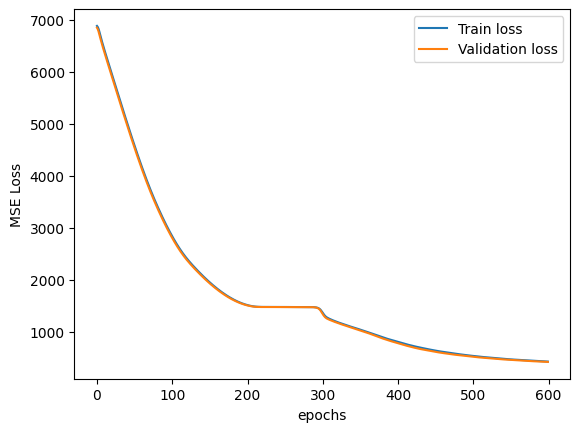

In [12]:
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.savefig('/kaggle/working/loss_curve.png',dpi=300)
plt.show()